# Custom Model: Resnet18 and DistilBert

##Data

###Download COCO Dataset

In [ ]:
# https://cocodataset.org/#download

# Images
!wget -c http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip
!rm train2014.zip

!wget -c http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip
!rm val2014.zip

# Captions
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip
!rm annotations_trainval2014.zip

###Karpathy Split

In [78]:
import torch
from torchvision.datasets import CocoCaptions
from torchvision.transforms import PILToTensor
from torch.utils.data import ConcatDataset, random_split
from torchvision.models import ResNet18_Weights

# Karpathy split (https://arxiv.org/pdf/1412.2306.pdf)

# for reproducibility
torch.manual_seed(42)

train_2014_ds = CocoCaptions(
    root = 'train2014/',
    annFile = 'annotations/captions_train2014.json',
    transform = ResNet18_Weights.IMAGENET1K_V1.transforms(),
    target_transform = lambda x: x[:5]
)
val_2014_ds = CocoCaptions(
    root = 'val2014/',
    annFile = 'annotations/captions_val2014.json',
    transform=ResNet18_Weights.IMAGENET1K_V1.transforms(),
    target_transform = lambda x: x[:5]
)

train_ds, val_ds, test_ds = random_split(val_2014_ds, [len(val_2014_ds) - 10000, 5000, 5000])
train_ds = ConcatDataset([train_2014_ds, train_ds])


loading annotations into memory...
Done (t=1.82s)
creating index...
index created!
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!


In [79]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [80]:
print(f'Training set size: {len(train_ds)}')
print(f'Validation set size: {len(val_ds)}')
print(f'Test set size: {len(test_ds)}')

Training set size: 113287
Validation set size: 5000
Test set size: 5000


## Custom Model

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [82]:
# https://arxiv.org/pdf/2103.00020.pdf
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from transformers import DistilBertTokenizerFast, DistilBertModel
from tqdm.auto import tqdm

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # image encoder
        # https://pytorch.org/vision/stable/models.html
        self.image_encoder = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
        self.image_encoder.fc = nn.Identity()
        # freeze encoder parameters
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        self.ie_linear_1 = nn.Linear(512,256)
        self.ie_linear_2 = nn.Linear(256,128)

        # text encoder
        # https://huggingface.co/distilbert/distilbert-base-uncased
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
        # freeze encoder parameters
        for param in self.text_encoder.parameters():
            param.requires_grad = False
        self.te_linear_1 = nn.Linear(768,256)
        self.te_linear_2 = nn.Linear(256,128)


    def forward(self, images, texts):

        images = self.image_encoder(images)
        images = F.relu(self.ie_linear_1(images))
        images = F.normalize(self.ie_linear_2(images))

        texts = self.text_encoder(**texts)
        texts = texts.last_hidden_state[:,0,:] # cls token
        texts = F.relu(self.te_linear_1(texts))
        texts = F.normalize(self.te_linear_2(texts))

        cosine_similartiy = images @ texts.T


        return cosine_similartiy


In [83]:
import gdown

load_checkpoint = True
ckpt_url = 'https://drive.google.com/file/d/1YVByA2v4AnnZ67vrdY13X5tLl-0w-OCy/view?usp=sharing'
ckpt_path = './ckpt.pt'

gdown.download(ckpt_url, ckpt_path, fuzzy=True)

# model
model = Model().to(device)
if load_checkpoint and os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device(device)))
    print("Loaded checkpoint")
print(model)

Downloading...
From (original): https://drive.google.com/uc?id=1YVByA2v4AnnZ67vrdY13X5tLl-0w-OCy
From (redirected): https://drive.google.com/uc?id=1YVByA2v4AnnZ67vrdY13X5tLl-0w-OCy&confirm=t&uuid=3ea739bc-72a6-42bb-b329-f13bcadf8c81
To: /content/ckpt.pt
100%|██████████| 312M/312M [00:05<00:00, 56.4MB/s]


Loaded checkpoint
Model(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

##Loss Function

In [84]:
# https://towardsdatascience.com/clip-model-and-the-importance-of-multimodal-embeddings-1c8f6b13bf72

def Loss(cosine_similartiy):

    num_captions_per_image = 5
    batch_size = cosine_similartiy.size(0)

    loss_images, loss_texts = 0, 0
    labels = torch.arange(batch_size).to(device)

    for i in range(num_captions_per_image):
        loss_images += F.cross_entropy(cosine_similartiy[:,i*batch_size:(i+1)*batch_size], labels)
        loss_texts += F.cross_entropy(cosine_similartiy[:,i*batch_size:(i+1)*batch_size].T, labels)

    loss = (loss_images + loss_texts) / 2

    return loss


##Evaluate

In [85]:
def evaluate(model, data_loader):

    loss = 0
    correct_matches = 0
    total_samples = 0

    model.eval()
    for images, captions in tqdm(data_loader):

        images = images.to(device)
        captions = [c for captions_tuple in captions for c in captions_tuple]
        captions = tokenizer(captions, return_tensors='pt', padding=True, truncation=True).to(device)
        cosine_similartiy = model(images, captions)

        loss += Loss(cosine_similartiy).detach().to('cpu')

        # accuracy
        predictions = cosine_similartiy.argmax(dim=1)
        predictions = predictions % len(images)
        correct_matches += (predictions == torch.arange(len(images)).to(device)).sum().item()
        total_samples += len(images)

    loss /= len(data_loader)
    accuracy = correct_matches / total_samples

    return loss, accuracy


##Train

In [86]:
# settings
epochs = 10
learning_rate = 0.001

# save checkpoint
ckpt_folder = '/content/drive/MyDrive/CS445/final_project/ckpt'

# tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# keep min validation loss
min_loss = 23.572

# train
train = False
if train:
    for epoch in range(epochs):

        train_loss = 0

        model.train()
        for images, captions in tqdm(train_dataloader):

            images = images.to(device)
            captions = [c for captions_tuple in captions for c in captions_tuple]
            captions = tokenizer(captions, return_tensors='pt', padding=True, truncation=True).to(device)
            cosine_similartiy = model(images, captions)

            optimizer.zero_grad()
            loss = Loss(cosine_similartiy)
            loss.backward()
            optimizer.step()

            train_loss += loss

        train_loss /= len(train_dataloader)

        val_loss, val_accuracy = evaluate(model, val_dataloader)

        if val_loss < min_loss:
            torch.save(model.state_dict(), f"{ckpt_folder}/{epoch+9}_{'{:.3f}'.format(val_loss)}.pt")
            min_loss = val_loss

        print(f"Epoch: {epoch+9} \t Train Loss: {'{:.3f}'.format(train_loss)} \t Validation Loss: {'{:.3f}'.format(val_loss)} \t Validation Accuracy: {'{:.3f}'.format(val_accuracy)}")


## Test

In [87]:
test = False
if test:
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print(f"Test Loss: {'{:.3f}'.format(test_loss)} \t Test Accuracy: {'{:.3f}'.format(test_accuracy)}")


## Video Search

### Download Video

In [23]:
!pip install -U yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.4 MB/s eta 0:00:00


In [24]:
# lion king trailer
# !yt-dlp -F https://www.youtube.com/watch?v=7TavVZMewpY - finds available formats

!yt-dlp -f 136 -o /content/drive/MyDrive/CS445/final_project/lion_king.mp4 https://www.youtube.com/watch?v=7TavVZMewpY

[youtube] Extracting URL: https://www.youtube.com/watch?v=7TavVZMewpY
[youtube] 7TavVZMewpY: Downloading webpage
[youtube] 7TavVZMewpY: Downloading ios player API JSON
[youtube] 7TavVZMewpY: Downloading android player API JSON
[youtube] 7TavVZMewpY: Downloading player 5d0dbf62
[youtube] 7TavVZMewpY: Downloading m3u8 information
[info] 7TavVZMewpY: Downloading 1 format(s): 136
[download] /content/drive/MyDrive/CS445/final_project/lion_king.mp4 has already been downloaded
[download] 100% of    1.23MiB


### Extract Frames

In [25]:
import cv2
import numpy as np
from tqdm.auto import tqdm

video = cv2.VideoCapture('/content/drive/MyDrive/CS445/final_project/lion_king.mp4')

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
channels = 3

num_frames, frames = 0, None
for i in tqdm(range(total_frames)):
    ret, frame = video.read()
    # every 0.5 second, otherwise processing takes too long
    if i % (fps//2) == 0:
        frame = frame[np.newaxis, :]
        frames = frame if frames is None else np.concatenate((frames,frame), axis=0)
        num_frames += 1

video.release()

  0%|          | 0/2606 [00:00<?, ?it/s]

### Custom Model Search

In [76]:
# inspired by Video Google? lecture 12

from torchvision.models import ResNet18_Weights

batch_size = 32
search_texts = ["Sunset", "Antelope", "Lion", "Hog"]

transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
logits = np.zeros((num_frames,len(search_texts)))

# extract text features
texts = tokenizer(search_texts, return_tensors='pt', padding=True, truncation=True).to(device)

# needed to avoid out of memory errors
model.eval()
with torch.no_grad():
    for i in tqdm(range((num_frames-1)//batch_size+1)):

        start_idx, end_idx = i*batch_size, min((i+1)*batch_size,num_frames)

        # extract image features
        images = torch.from_numpy(np.moveaxis(frames[start_idx:end_idx],3,1)) # b,h,w,c -> b,c,h,w
        images = transforms(images).to(device)

        # feed into model
        outputs = model(images, texts)
        logits[start_idx: end_idx] = outputs.detach().to('cpu')



  0%|          | 0/8 [00:00<?, ?it/s]

### Custom Model Results

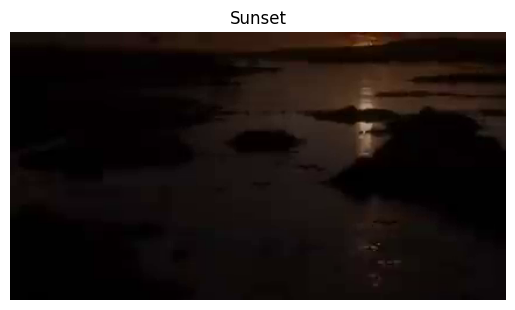

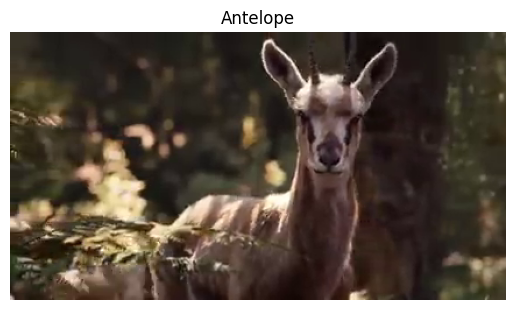

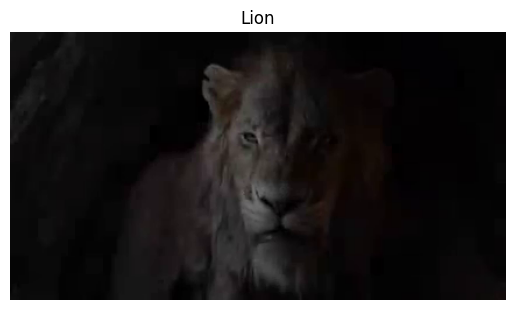

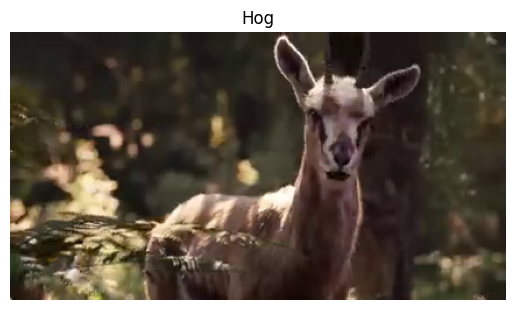

In [77]:
from matplotlib import pyplot as plt

image_idx = np.argmax(logits, axis=0)

for i, img in enumerate(image_idx):
    plt.figure()
    plt.title(search_texts[i])
    plt.axis('off')
    plt.imshow(frames[img][:,:,[2,1,0]]);